# TBS_BESAR_MCL_GLASS_CLASSIFICATION

#### 1.  Menyiapkan library dan dataset yang akan digunakan, Load library dan explorasi dataset

import library untuk evaluasi model yang akan digunakan, terdapat 4 model evaluasi yang akan di coba pada dataset ini, yaitu decision tree, logistic regression,knn dan random forest classifier

In [100]:
import numpy as np #untuk array
import pandas as pd #untuk dataframes
import seaborn as sns #untuk library visualisasi statistikal
import matplotlib.pyplot as plt #untuk visualisasi
from sklearn.cross_validation import train_test_split #untuk menghitung nilai skor evaluasi model
from sklearn import cross_validation
from sklearn.model_selection import (cross_val_score,StratifiedKFold)
from sklearn import preprocessing

from collections import Counter
from sklearn.pipeline import Pipeline # streaming pipelines
from sklearn.preprocessing import (FunctionTransformer, StandardScaler) # untuk preprocessing 
from time import time

#load model yang akan digunakan
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [101]:
data=pd.read_csv('glass.csv')
features=data.columns[:-1].tolist()
print(data.shape)

(214, 10)


#dataset glass terdiri dari 214 baris/observasi

In [102]:
data.head(15)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,TypeofGlass
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.00,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00,1
5,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26,1
6,1.51743,13.30,3.60,1.14,73.09,0.58,8.17,0.0,0.00,1
7,1.51756,13.15,3.61,1.05,73.24,0.57,8.24,0.0,0.00,1
8,1.51918,14.04,3.58,1.37,72.08,0.56,8.30,0.0,0.00,1
9,1.51755,13.00,3.60,1.36,72.99,0.57,8.40,0.0,0.11,1


In [103]:
data.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,TypeofGlass
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


#Rata rata fitur SI adalah 72.65 dan rata rata fitur Fe adalah 0.057. Untuk menggunakan 
model logistic regression, disarankan bahwa fitur harus memiliki skala yang sama. Untuk membuktikannya kita akan coba, dengan model ini. Untuk melihat distribusi data berdasarkan tipe:

In [104]:
data['TypeofGlass'].value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: TypeofGlass, dtype: int64

Dataset ini tidak imbang, dataset yang paling banyak adalah tipe glass 1 dan 2 

###### 2. Data Preprocessing, mencari dan menghilangkan multiple outliers

#outlier adalah data yang menyimpang terlalu jauh dari data yang lainnya dalam suatu rangkaian data. 
Untuk menghilangkannya kita gunakan metode Turkey.

Melihat fitur yang memiliki koefisien miring tertinggi.

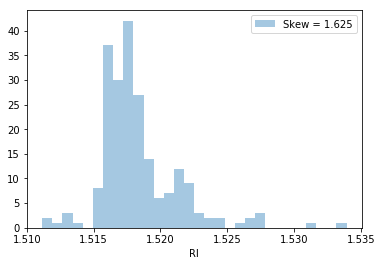

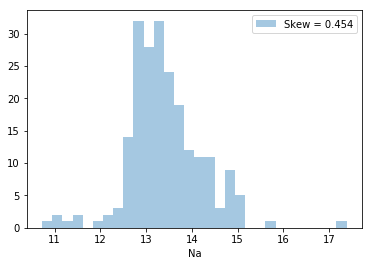

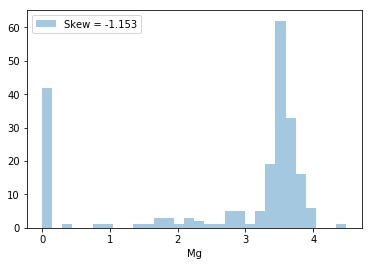

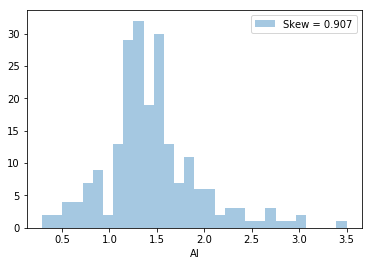

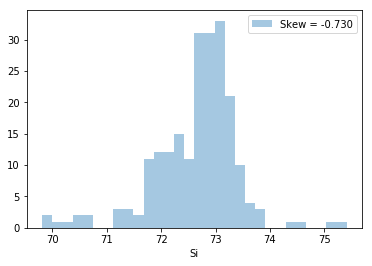

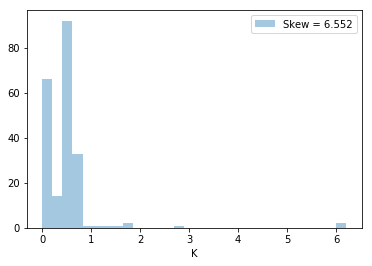

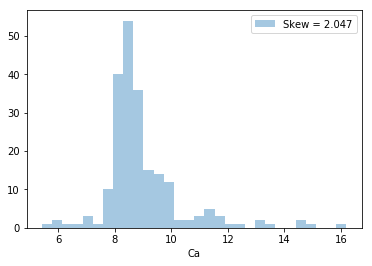

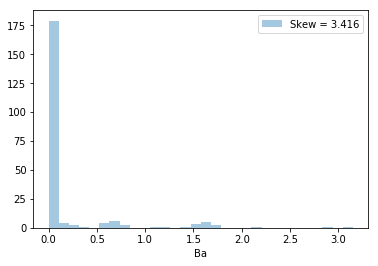

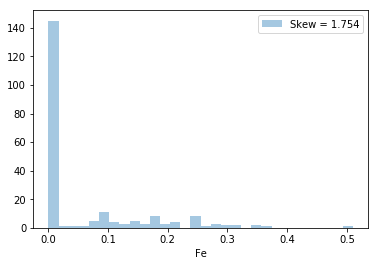

In [105]:
for feat in features:
    skew = data[feat].skew()
    sns.distplot(data[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

In [106]:
# Detect observations with more than one outlier

def outlier_hunt(data):
    """
    Takes a dataframe data of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in data.columns.tolist():
        # 1st quartile (25%)
        Q1 = np.percentile(data[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(data[col],75)
        
        # Interquartile rrange (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = data[(data[col] < Q1 - outlier_step) | (data[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

print('dataset ini terdiri dari %d baris observasi dengan lebih dari 2 outliers' %(len(outlier_hunt(data[features]))))   

dataset ini terdiri dari 14 baris observasi dengan lebih dari 2 outliers


#terdapat 14 baris observasi dengan banyak outliers, 
hal ini dapat menggangu efisiensi dari model algoritma 
yang akan digunakan

In [107]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
RI             214 non-null float64
Na             214 non-null float64
Mg             214 non-null float64
Al             214 non-null float64
Si             214 non-null float64
K              214 non-null float64
Ca             214 non-null float64
Ba             214 non-null float64
Fe             214 non-null float64
TypeofGlass    214 non-null int64
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


# Menghilangkan data dengan outliers yang lebih dari 2, menyisakan sebesar 200 data

In [108]:
outlier_indices = outlier_hunt(data[features])
data = data.drop(outlier_indices).reset_index(drop=True)
print(data.shape)

(200, 10)


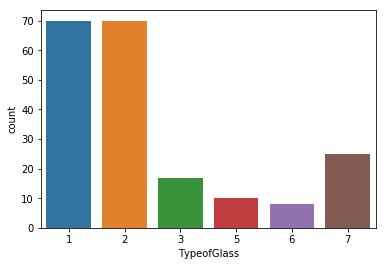

In [109]:
sns.countplot(data['TypeofGlass'])
plt.show()

# Split-out validation dataset

memisahkan data training dan data test, kita mengambil data test sebanyak 25% dari data, berarti terdapat 50 dataset untuk test


In [110]:
#Define X as features and y as lablels
feature = data[features] 
label = data['TypeofGlass'] 
# set a seed and a test size for splitting the dataset 
#metode seed akan menginisialisasi nilai yang akan digunakan untuk mengenerate nomor random, kita gunakan 7
seed = 7
test_size = 0.25

X_train, X_test, y_train, y_test = train_test_split(feature, label, test_size = test_size , random_state = seed)

###### 3 Pembuatan dan Evaluasi Model

#Mencari algoritma yang terbaik untuk digunakan dengan dataset kaca,dan akan digunakan model evaluasi k-fold cross validation dengan jumlah fold 10
n_splits adalah berapa jumlah iterasi yang akan terjadi pada cross validasi,shuffle dan random state untuk membuat split test dataset kfold lebih baik

In [111]:
#Pembuatan Model untuk dievaluasi dan dipilih model yang terbaik
modelLogReg=LogisticRegression()
modelRForest=RandomForestClassifier(n_estimators=200,random_state=seed)
#memainkan dengan parameter untuk mencari hasil score terbaik
modelDTree=DecisionTreeClassifier()
modelKnn=KNeighborsClassifier()

# Cross Validation Score

In [112]:
from sklearn.model_selection import KFold

kfold=KFold(n_splits=10,shuffle=True,random_state=0)
#Scoring Model dengan 

scoreKfoldLogReg=cross_val_score(modelLogReg,feature,label,cv=kfold)
scorekfoldRForest=cross_val_score(modelRForest,feature,label,cv=kfold)
scorekfoldDTree=cross_val_score(modelDTree,feature,label,cv=kfold)
scorekfoldKnn=cross_val_score(modelKnn,feature,label,cv=kfold)


print("Cross Validation Score [LogReg]: {}".format(scoreKfoldLogReg))
print("Rata Rata Cross Validation Score LogReg {:2f}".format(scoreKfoldLogReg.mean()))
print("-----------------------------------------------------------------------------")
print("Cross Validation Score [RandomForestClassifier]: {}".format(scorekfoldRForest))
print("Rata Rata Cross Validation Score RandomForestClassifier {:2f}".format(scorekfoldRForest.mean()))
print("-----------------------------------------------------------------------------")
print("Cross Validation Score [DecisionTreeClassifier]: {}".format(scorekfoldDTree))
print("Rata Rata Cross Validation Score DecisionTreeClassifier {:2f}".format(scorekfoldDTree.mean()))
print("-----------------------------------------------------------------------------")
print("Cross Validation Score [KnnClassifier]: {}".format(scorekfoldKnn))
print("Rata Rata Cross Validation Score KnnClassifier {:2f}".format(scorekfoldKnn.mean()))

Cross Validation Score [LogReg]: [ 0.55  0.7   0.65  0.55  0.75  0.8   0.75  0.55  0.6   0.65]
Rata Rata Cross Validation Score LogReg 0.655000
-----------------------------------------------------------------------------
Cross Validation Score [RandomForestClassifier]: [ 0.7   0.8   0.7   0.75  0.8   0.9   0.85  0.8   0.8   0.7 ]
Rata Rata Cross Validation Score RandomForestClassifier 0.780000
-----------------------------------------------------------------------------
Cross Validation Score [DecisionTreeClassifier]: [ 0.7   0.6   0.65  0.65  0.6   0.7   0.6   0.65  0.5   0.75]
Rata Rata Cross Validation Score DecisionTreeClassifier 0.640000
-----------------------------------------------------------------------------
Cross Validation Score [KnnClassifier]: [ 0.65  0.65  0.75  0.6   0.7   0.8   0.65  0.55  0.65  0.75]
Rata Rata Cross Validation Score KnnClassifier 0.675000


# Confussion Matrix

In [113]:
#evaluasi terkait prediksi dari model yang sudah dibuat dengan confusion_matrix


modelLogReg.fit(X_train,y_train)
predict_logReg=modelLogReg.predict(X_test)


modelRForest.fit(X_train,y_train)
predict_RForest=modelRForest.predict(X_test)

modelDTree.fit(X_train,y_train)
predict_Dtree=modelDTree.predict(X_test)


modelKnn.fit(X_train,y_train)
predict_Knn=modelKnn.predict(X_test)


from sklearn.metrics import confusion_matrix
confusionLogReg=confusion_matrix(y_test,predict_logReg)
print("Confusion matrix Logistic Regression: \n{}".format(confusionLogReg))

confusionRforest=confusion_matrix(y_test,predict_RForest)
print("Confusion matrix Random Forest: \n{}".format(confusionRforest))
      
confusionDtree=confusion_matrix(y_test,predict_Dtree)
print("Confusion matrix Decission Tree: \n{}".format(confusionDtree))
      
confusionKnn=confusion_matrix(y_test,predict_Knn)
print("Confusion matrix Knn: \n{}".format(confusionKnn))

Confusion matrix Logistic Regression: 
[[13  1  0  0  0  0]
 [ 9 11  0  2  0  0]
 [ 2  2  0  0  0  0]
 [ 0  0  0  1  0  0]
 [ 0  1  0  0  0  0]
 [ 0  0  0  1  0  7]]
Confusion matrix Random Forest: 
[[13  1  0  0  0  0]
 [ 3 16  1  2  0  0]
 [ 1  1  2  0  0  0]
 [ 0  0  0  1  0  0]
 [ 0  0  0  0  1  0]
 [ 0  0  0  1  0  7]]
Confusion matrix Decission Tree: 
[[11  1  2  0  0  0]
 [ 7 10  2  2  0  1]
 [ 0  1  3  0  0  0]
 [ 0  0  0  1  0  0]
 [ 0  0  0  0  1  0]
 [ 0  0  0  1  0  7]]
Confusion matrix Knn: 
[[13  0  1  0  0  0]
 [ 8 11  0  1  2  0]
 [ 3  0  1  0  0  0]
 [ 0  0  0  1  0  0]
 [ 0  0  0  0  1  0]
 [ 0  1  0  0  1  6]]


Confusion matrix, without normalization
[[13  1  0  0  0  0]
 [ 3 16  1  2  0  0]
 [ 1  1  2  0  0  0]
 [ 0  0  0  1  0  0]
 [ 0  0  0  0  1  0]
 [ 0  0  0  1  0  7]]


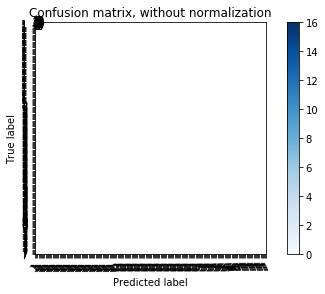

In [114]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
plt.figure()
plot_confusion_matrix(confusionRforest, classes=label,
                      title='Confusion matrix, without normalization')


plt.show()

# Recall Score

nilai recall adalah rasio tp / (tp + fn) di mana tp adalah jumlah true positive dan fn jumlah false negative.
nilai recall  secara intuitif adalah kemampuan pengklasifikasi untuk menemukan semua sampel positif.

Nilai terbaik adalah 1 dan nilai terburuknya adalah 0.

parameter rata rata menggunakan macro: menghitung metrik secara mandiri untuk setiap kelas dan kemudian mengambil rata-rata (sehingga memperlakukan semua kelas dengan sama)

In [115]:
from sklearn.metrics import recall_score

print("recall score logistic regression {:.2f}".format(recall_score(y_test,predict_logReg,average='macro')))
print("recall score Random Forest :{:.2f}".format(recall_score(y_test,predict_RForest,average='macro')))
print("recall score Decission Tree :{:.2f}".format(recall_score(y_test,predict_Dtree,average='macro')))
print("recall score knn :{:.2f}".format(recall_score(y_test,predict_Knn,average='macro')))


recall score logistic regression 0.55
recall score Random Forest :0.84
recall score Decission Tree :0.81
recall score knn :0.74


# Precision Score

Precision secara intuitif adalah kemampuan pengklasifikasi untuk tidak memberi label positif sebagai sampel yang negatif.

Nilai terbaik adalah 1 dan nilai terburuknya adalah 0.

parameter rata rata menggunakan macro: menghitung metrik secara mandiri untuk setiap kelas dan kemudian mengambil rata-rata (sehingga memperlakukan semua kelas dengan sama)

In [116]:
from sklearn.metrics import precision_score


print("precission score logistic regression {:.2f}".format(precision_score(y_test,predict_logReg,average='macro')))
print("precission score Random Forest :{:.2f}".format(precision_score(y_test,predict_RForest,average='macro')))
print("precission score Decission Tree :{:.2f}".format(precision_score(y_test,predict_Dtree,average='macro')))
print("precission score knn :{:.2f}".format(precision_score(y_test,predict_Knn,average='macro')))

precission score logistic regression 0.42
precission score Random Forest :0.76
precission score Decission Tree :0.67
precission score knn :0.62


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# f1 score
Skor F1 dapat diartikan sebagai rata-rata tertimbang dari nilai precision dan nilai recall, 
di mana skor F1 mencapai nilai terbaiknya pada 1 dan skor terburuk di 0. 
Kontribusi relatif dari presisi dan recall ke skor F1 adalah sama.


parameter rata rata menggunakan macro: menghitung metrik secara mandiri untuk setiap kelas dan kemudian mengambil rata-rata (sehingga memperlakukan semua kelas dengan sama)

In [117]:
from sklearn.metrics import f1_score


print("f1 score logistic regression {:.2f}".format(f1_score(y_test,predict_logReg,average='macro')))
print("f1 score Random Forest :{:.2f}".format(f1_score(y_test,predict_RForest,average='macro')))
print("f1 score Decission Tree :{:.2f}".format(f1_score(y_test,predict_Dtree,average='macro')))
print("f1 score knn :{:.2f}".format(f1_score(y_test,predict_Knn,average='macro')))

f1 score logistic regression 0.44
f1 score Random Forest :0.76
f1 score Decission Tree :0.68
f1 score knn :0.60


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Accuracy Score
Fungsi accuracy_score menghitung akurasi, baik fraksi (default) atau hitungan (menormalkan = False) dari prediksi yang benar.

Dalam klasifikasi multilabel, fungsi mengembalikan akurasi subset. Jika seluruh rangkaian label prediksi untuk sampel secara ketat sesuai dengan kumpulan label yang benar, maka akurasi subset adalah 1,0; selain itu adalah 0,0.

normalisasi adalah false, akan kembalikan jumlah sampel yang diklasifikasikan dengan benar. Jika tidak, kembalikan pecahan dari sampel yang diklasifikasikan dengan benar.


In [118]:
from sklearn.metrics import accuracy_score


print("akurasi score logistic regression {:.2f}".format(accuracy_score(y_test,predict_logReg,normalize=False)))
print("akurasi score Random Forest :{:.2f}".format(accuracy_score(y_test,predict_RForest,normalize=False)))
print("akurasi score Decission Tree :{:.2f}".format(accuracy_score(y_test,predict_Dtree,normalize=False)))
print("akurasi score knn :{:.2f}".format(accuracy_score(y_test,predict_Knn,normalize=False)))

akurasi score logistic regression 32.00
akurasi score Random Forest :40.00
akurasi score Decission Tree :33.00
akurasi score knn :33.00


C:\tools\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


DT: 66.070941 (+/- 14.556065) performed in 13.419098 seconds


C:\tools\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


KNN: 65.874949 (+/- 11.949835) performed in 15.340097 seconds


C:\tools\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


RF: 76.927516 (+/- 11.402392) performed in 16.487599 seconds


C:\tools\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


LR: 71.795540 (+/- 8.815315) performed in 15.949418 seconds


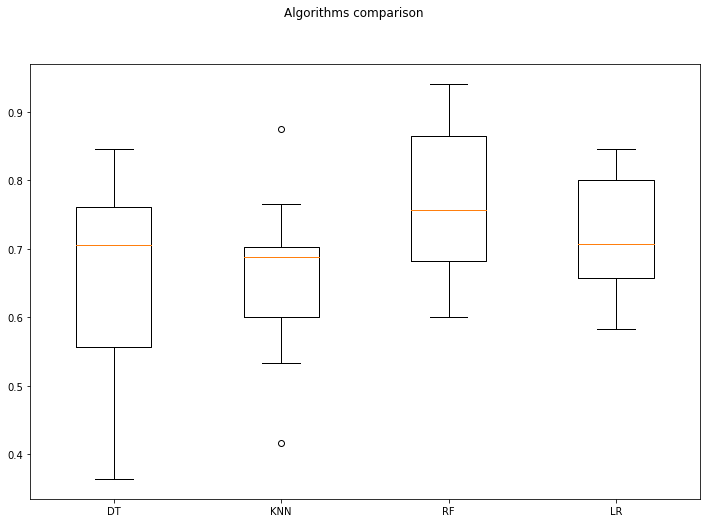

In [119]:
n_components = 5
pipelines = []
n_estimators = 200

#print(df.shape)
pipelines.append( ('DT',
                   Pipeline([
                              ('sc', StandardScaler()),
#                               ('pca', PCA(n_components = n_components, random_state=seed ) ),
                             ('DT', DecisionTreeClassifier(random_state=seed))]) ) )


pipelines.append(('KNN',
                  Pipeline([ 
                              ('sc', StandardScaler()),
#                             ('pca', PCA(n_components = n_components, random_state=seed ) ),
                            ('KNN', KNeighborsClassifier()) ])))
pipelines.append( ('RF',
                   Pipeline([
                              ('sc', StandardScaler()),
#                              ('pca', PCA(n_components = n_components, random_state=seed ) ), 
                             ('RF', RandomForestClassifier(random_state=seed, n_estimators=n_estimators)) ]) ))

pipelines.append( ('LR',
                   Pipeline([
                              ('sc', StandardScaler()),
#                               ('pca', PCA(n_components = n_components, random_state=seed ) ), 
                             ('LR', LogisticRegression(random_state=seed)) ]) ))



results, names, times  = [], [] , []
num_folds = 10
scoring = 'accuracy'

for name, model in pipelines:
    start = time()
    kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring = scoring,
                                n_jobs=-1) 
    t_elapsed = time() - start
    results.append(cv_results)
    names.append(name)
    times.append(t_elapsed)
    msg = "%s: %f (+/- %f) performed in %f seconds" % (name, 100*cv_results.mean(), 
                                                       100*cv_results.std(), t_elapsed)
    print(msg)

fig = plt.figure(figsize=(12,8))    
fig.suptitle("Algorithms comparison")
ax = fig.add_subplot(1,1,1)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Model/algoritma yang memiliki performa terbaik jatuh kepada model random forest
random forest juga menghasilkan distribusi yang luas.

dengan hasil score:


Cross validation score :  0.78



Precision Score: 0.76

Recall Score: 0.84

F1 score :  0.76

Akurasi score: 40.00

In [120]:

print("Confusion matrix Random Forest: \n{}".format(confusionRforest))

Confusion matrix Random Forest: 
[[13  1  0  0  0  0]
 [ 3 16  1  2  0  0]
 [ 1  1  2  0  0  0]
 [ 0  0  0  1  0  0]
 [ 0  0  0  0  1  0]
 [ 0  0  0  1  0  7]]


###### 4 Membuat Model Machine Learning menggunakan Random Forest

In [121]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

pipe=Pipeline([("scaler",MinMaxScaler()),("randomForest",RandomForestClassifier(n_estimators=200,random_state=seed))])

pipe.fit(X_train,y_train)



print("Memprediksi akurasi dengan test set model Random Forest")
print("Accuracy Score: "+str(pipe.score(X_test,y_test)))
y_pred=pipe.predict(X_test)
print(y_pred)
print(y_test)
tempRest = [pipe,data]

from sklearn.externals import joblib
joblib.dump(tempRest,'randomForestClassifier.pkl')
newClf = joblib.load('randomForestClassifier.pkl')

print(newClf)


Memprediksi akurasi dengan test set model Random Forest
Accuracy Score: 0.8
[2 3 1 1 7 2 2 2 1 1 2 1 1 1 5 1 1 1 3 1 7 2 3 2 7 6 2 7 2 7 1 5 5 2 2 2 2
 7 2 2 2 2 1 5 1 1 1 7 1 2]
86     2
120    2
22     1
11     1
195    7
2      1
121    2
94     2
66     1
63     1
108    2
96     2
138    2
65     1
188    7
155    3
24     1
99     2
153    3
46     1
178    7
139    2
143    3
74     2
186    7
169    6
101    2
197    7
109    2
177    7
57     1
106    2
160    5
84     2
124    2
85     2
126    2
183    7
80     2
116    2
129    2
128    2
60     1
122    2
27     1
40     1
45     1
191    7
31     1
154    3
Name: TypeofGlass, dtype: int64
[Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('randomForest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_sa